In [ ]:
#LIBRERIAS UTILIZADAS
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.special import binom
from scipy.stats import norm
from tabulate import tabulate

# Modulación LoRa

LoRa es una modulación de espectro expandido que utiliza la técnica chirp que consiste en modular el mensaje por medio de una señal que varía la frecuencia de manera continua y lineal.

## Parámetros de la modulación

**SF (Spreading factor)**

El spreading factor define dos valores fundamentales:

- El número de chips contenidos en cada símbolo y su valor viene dado por $2^{SF}$
- El número de bits que se codifica en cada simbolo y su valor es SF.

Para este tipo de modulacion su valor esta entre [7-12]

Por ejemplo:

-  Para un SF de 7, se tiene 128 chips por simbolo.

**Ts (Symbol time)**

Tiempo que tarda en enviarse un símbolo. Se calcula como $\frac{2^{SF}}{Bw}$

**Bw (BandWidth)**

Ancho de banda definido para la transmisión

**T (Tiempo de muestra)**

Delta de tiempo en el cual se toma una muestra $T$ = $\frac{1}{Bw}$

**s (Symbol)**

Símbolo a transmitir, toma valores entre $\{0,...,2^{SF}-1\}$

# WaveForm en frecuencia

A continuacion se muestra la forma de onda de la señal modulada en frecuencia para transmitir solo un simbolo.

Simbolo transmitido [80]


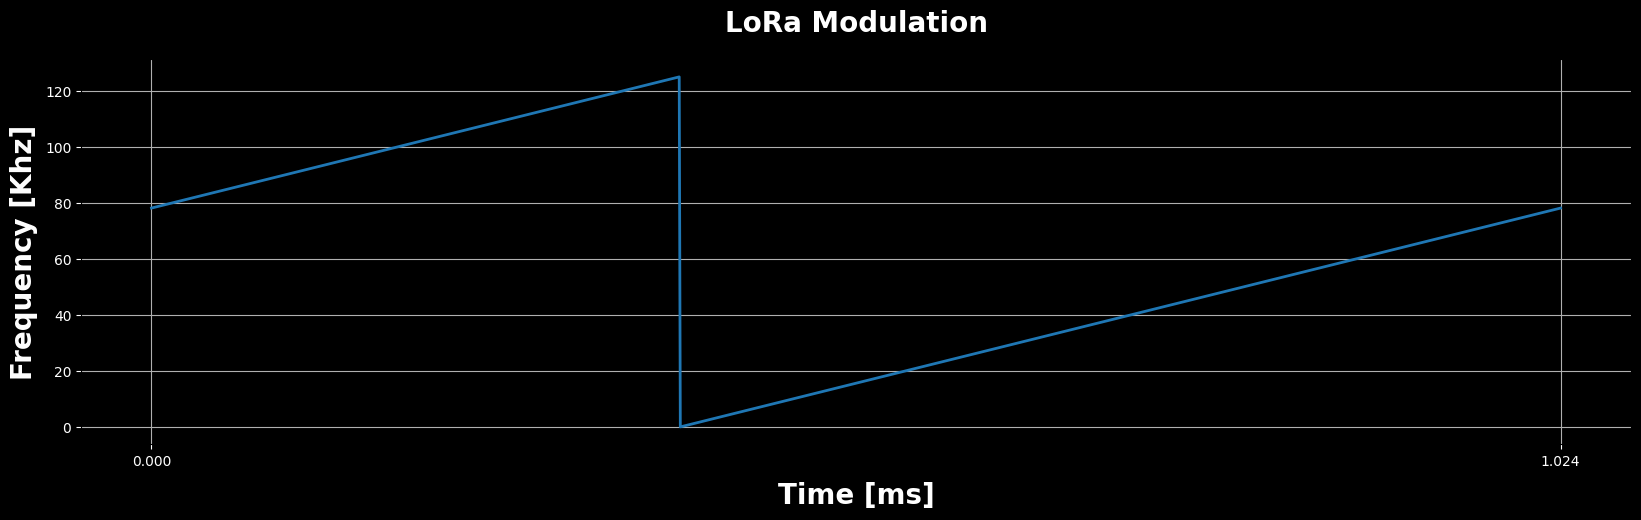

In [ ]:
#----------------------------- FUNCIONES ------------------------------------------------------------
def generate_chirp(simbolo, sf, Bw, time_interval, samples):

  M = 2**sf
  Ts = M/np.abs(Bw)
  wf_f = []

  for i in range(samples):
    wf_f.append((simbolo*np.abs(Bw)/M + Bw/Ts*time_interval[i]) % np.abs(Bw))

  return wf_f
def generate_symbols(sf, n_data, Bw, samples):

  data = []
  chirps = np.array([])
  t_c = np.linspace(0, Ts, samples)

  for i in range(n_data):
    data.append(np.random.randint(0, 2**sf))
    chirps = np.append(chirps, generate_chirp(data[i], sf, Bw, t_c, samples))

  return np.array(data), chirps

def plot_waveform(ax, t, wf, axis_x_label, axis_y_label, title, Ts, len_packet_tx):

  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
  ax.set_xticks(np.arange(0, len_packet_tx, Ts))
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
  ax.plot(t, wf, lw=2)
  ax.grid()

#------------------------------ MAIN --------------------------------------------------------------------------
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
n_data = 1 # numero de datos a transmitir
delta = 0.1
samples = int(2**sf*1/delta)
variance= 0.13

symbs, data_tx_f  = generate_symbols(sf, n_data, Bw, samples) # symbs son los datos generados aleatoriamente, data_tx son los crirp en frecuencia

print("Simbolo transmitido", symbs)
# Grafico Frecuencia vs tiempo
fig1, ax1 = plt.subplots(1, figsize = (20, 5))
fig1.patch.set_facecolor('black')

t = np.linspace(0, Ts, samples)

# Grafico Frecuencia vs tiempo
plot_waveform(ax1, t, data_tx_f, "Time [ms]", "Frequency [Khz]", "LoRa Modulation", Ts, samples)

Como se puede observar en las imagenes anteriores, el chirp se incrementa linealmente desde una frecuencia inicial (simbolo a transmitir) a una frecuencia maxima ${BW}$-$\frac{BW}{2^{SF}}$ . Una vez que llegue a la frecuencia maxima decae a la frecuencia 0 y se vuelve incrementar linealmente hasta el simbolo inicial.

# WaveForm en tiempo

A continuacion se muestra la forma de onda de la señal modulada en tiempo para transmitir solo un simbolo.

El siguiente codigo permite generar la waveform en tiempo con ruido gaussiano y sin ruido para ver las diferencias.

Parametros:
  - symb: Simbolo a transmitir (representa la frecuencia inicial de la waveform)
  - sf: spreading factor
  - Bw: ancho de banda del canal.
  - samples: Numero de muestras.

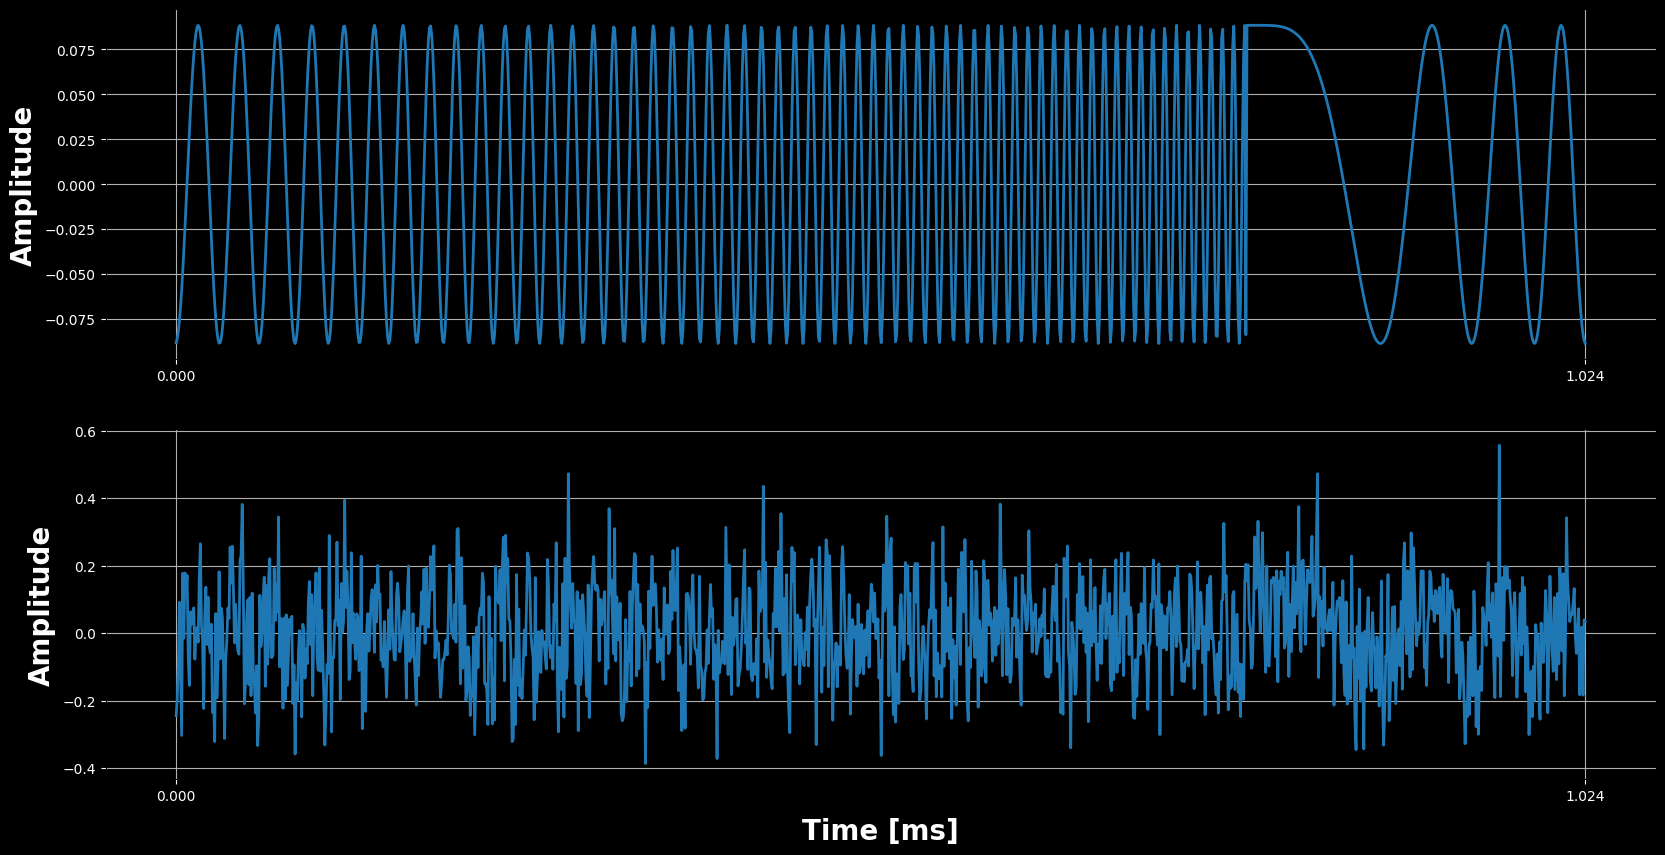

In [ ]:
#---------------------------------------------FUNCIONES-----------------------------------------------------
def waveform_chirp_time(symb, sf, Bw, delta, samples):

  Ts =2**sf
  T = 1/Bw
  wf = np.array([])

  fMax = (2**sf-1)*Bw/(2**sf)
  k = symb

  for n in range(samples):
    f = k*Bw/(2**sf)
    t = k*T
    if (f > fMax):
      k = k-Ts
      f = k*Bw/(2**sf)

    sample = (1/(np.sqrt(2**sf)))*np.exp(1j*2*np.pi*f*t*1/2)
    wf = np.append(wf, sample)

    k += delta

  return  wf
def add_noise_gaussiano(tx_signal, mean, variance):

  wn = generate_awgn(mean, variance, len(tx_signal))
  rx_signal = (tx_signal + wn)

  return rx_signal

def generate_awgn(mean, variance, samples):
  return np.random.normal(mean, variance, samples) #creando muestra de ruido

def plot_waveform(ax, t, wf, axis_x_label, axis_y_label, title, Ts, len_packet_tx):

  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
  ax.set_xticks(np.arange(0, len_packet_tx, Ts))
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
  ax.plot(t, wf, lw=2)
  ax.grid()

#---------------------------------------------MAIN----------------------------------------------------------
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
delta = 0.1
samples = int(2**sf*1/delta)
variance = 0.13

packet_tx_t = np.array([]) #waveform en tiempo

symb = 30 # simbolo a transmitir

packet_tx_t = np.append(packet_tx_t, waveform_chirp_time(symb, sf, Bw, delta, samples)) # chirp en tiempo

# Grafico Amplitud vs tiempo sin ruido gaussiano

fig1, [ax1, ax2] = plt.subplots(2, figsize = (20, 10))
fig1.patch.set_facecolor('black')

t = np.linspace(0, Ts, samples)

plot_waveform(ax1, t, np.real(packet_tx_t), "", "Amplitude", "", Ts, samples)

# Grafico Amplitud vs tiempo sin ruido gaussiano

rx_signal = add_noise_gaussiano(packet_tx_t, 0, variance) # waveform en tiempo con ruido gaussiano
plot_waveform(ax2, t, np.real(rx_signal), "Time [ms]", "Amplitude", "", Ts, samples)

# Transmision paquete completo de LoRa

Apartir de lo mostrado anteriormente sobre las formas de onda en frecuencia y tiempo para la transmision de un solo simbolo, en este apartado se va a mostrar la transmision de un paquete completo, incluye simbolo de preambulo, simbolo de sincronizacion y los datos mismos.

Se generan las waveform con 4 up-chirp de preambulo, 2 down-chirp de sincronizacion y 6 chirp de datos.

Aclaracion, se puede ajustar la cantidad de chirp de preambulo y de sincronizacion, siempre y cuando tanto el transmisor y receptor conozcan el mismo protocolo.

El siguiente codigo muestra la modulacion completa LoRa

<ipython-input-4-356521c54e0d>:146: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax1.stem(symbs[0:n_data], use_line_collection = True)


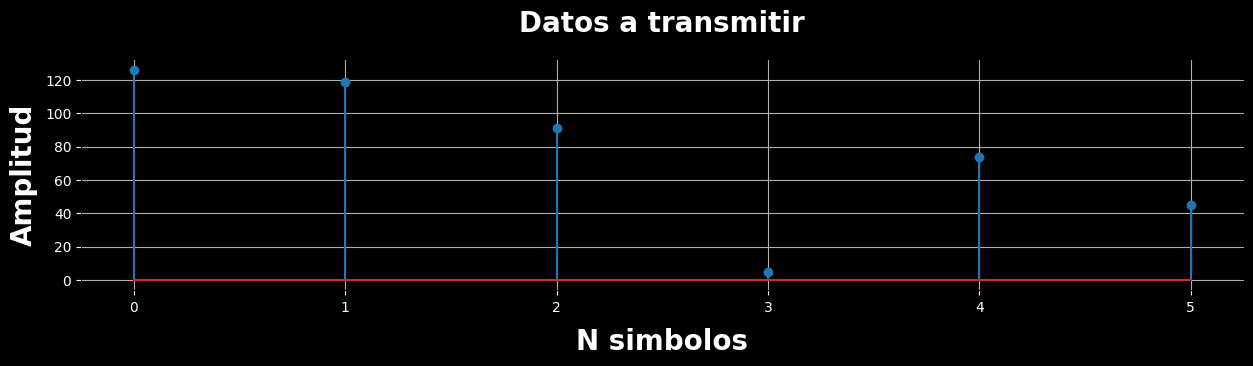

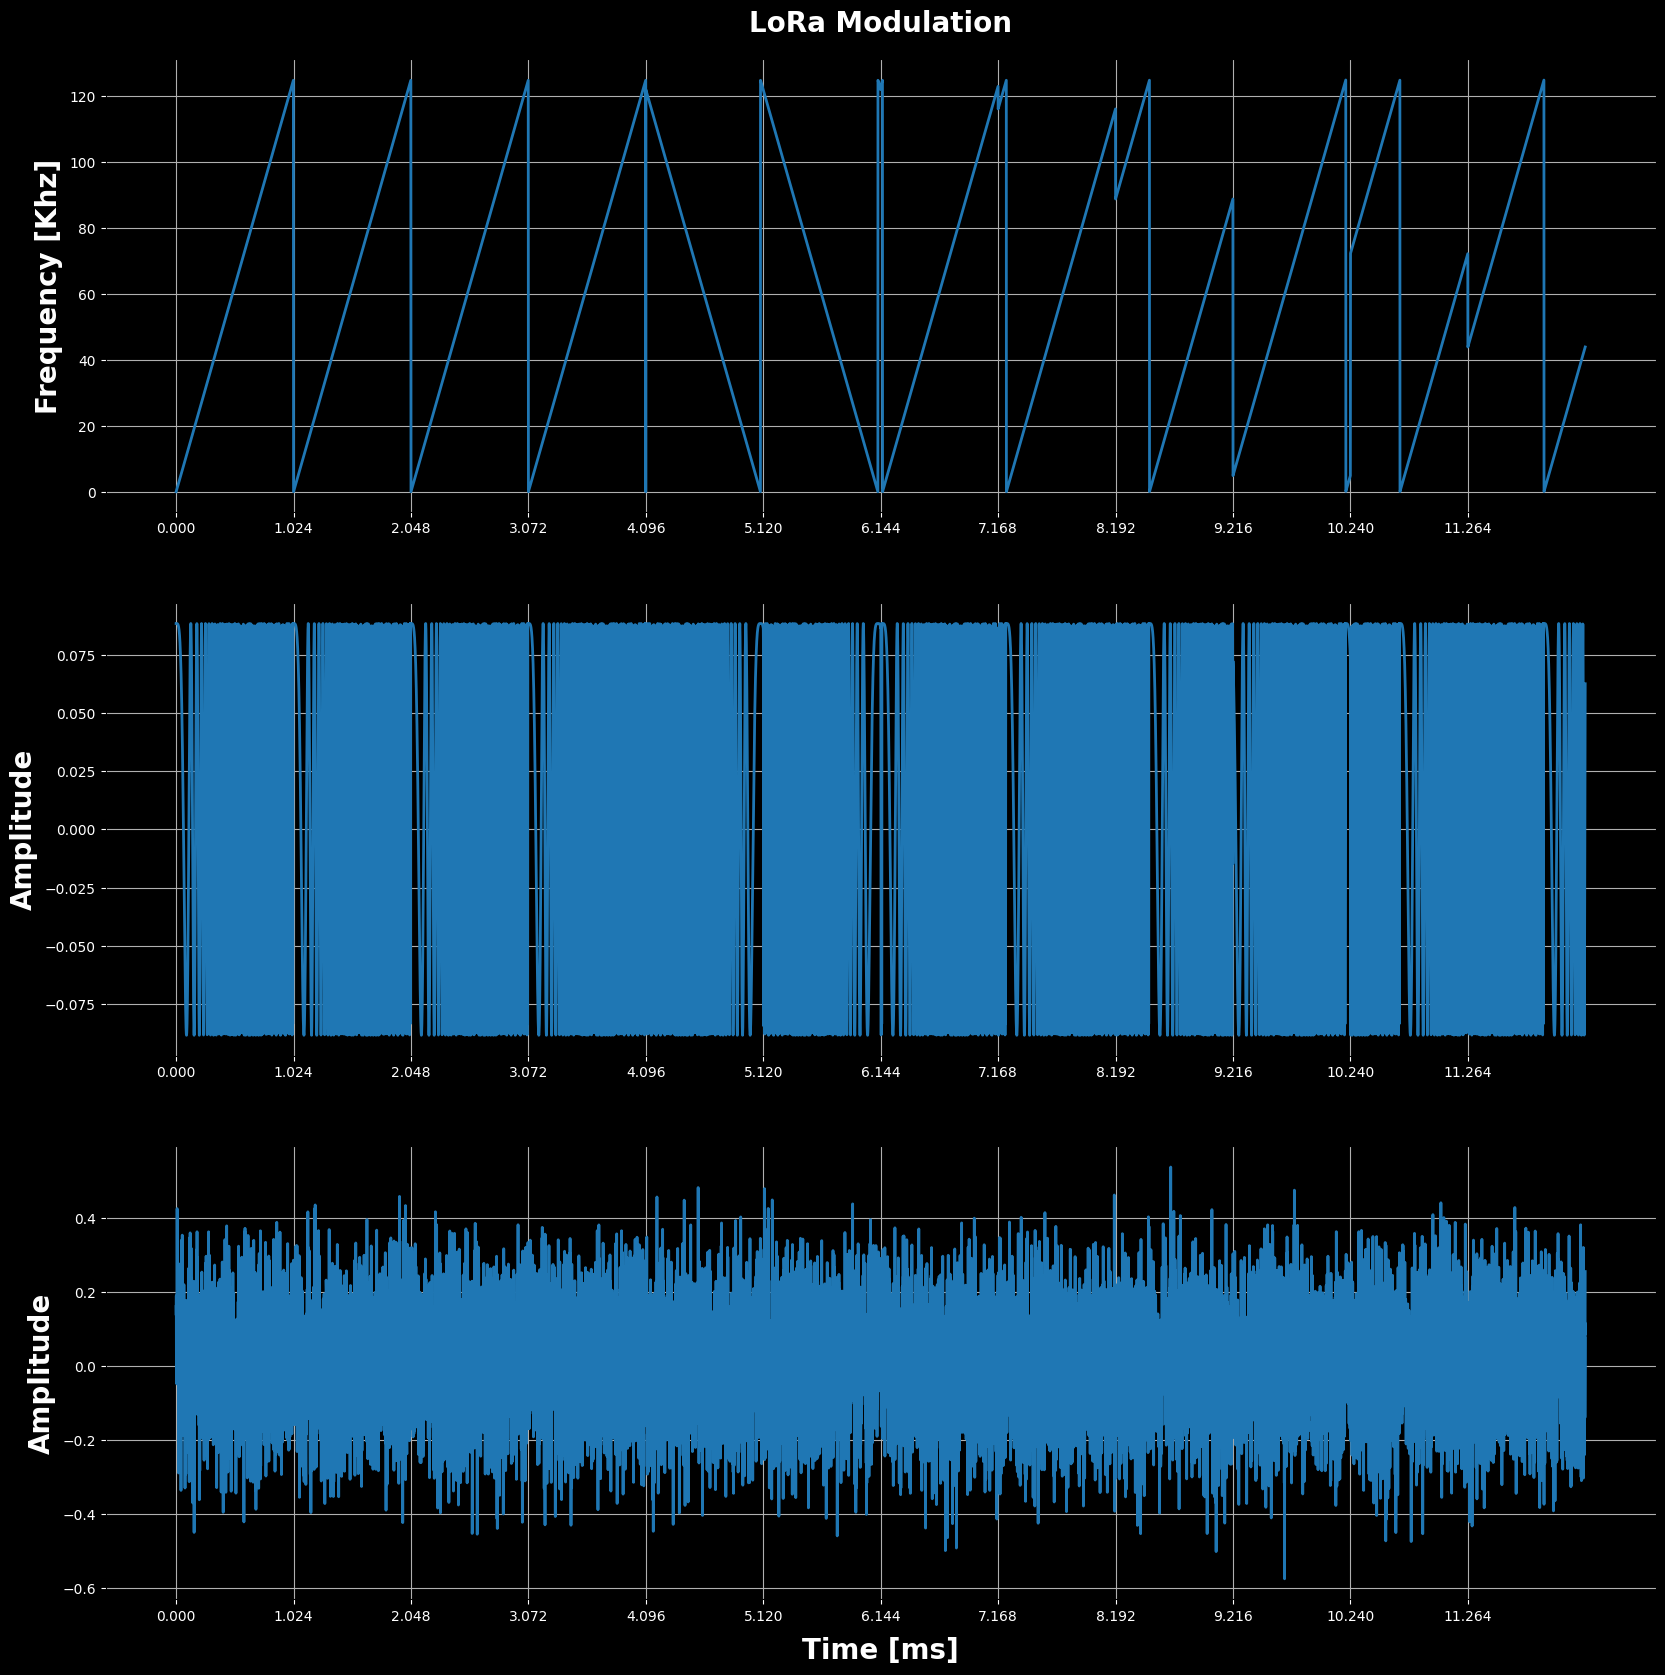

In [ ]:
#----------------------------- FUNCIONES ------------------------------------------------------------
# Genera el chirp de acuerdo al simbolo recibido: puede ser up-chirp, down-chirp
def generate_chirp(simbolo, sf, Bw, time_interval, samples):

  M = 2**sf
  Ts = M/np.abs(Bw)
  wf_f = []

  for i in range(samples):
    wf_f.append((simbolo*np.abs(Bw)/M + Bw/Ts*time_interval[i]) % np.abs(Bw))

  return wf_f
# Genera los simbolos aleatoriamente
def generate_symbols(sf, n_data, Bw, samples):

  data = []
  chirps = np.array([])
  t_c = np.linspace(0, Ts, samples)

  for i in range(n_data):
    data.append(np.random.randint(0, 2**sf))
    chirps = np.append(chirps, generate_chirp(data[i], sf, Bw, t_c, samples))

  return np.array(data), chirps

# Genera el simbolo de sincronizacion
def generate_sync(length_sync, Bw, sf, samples):

  f_0 = Bw
  M = 2**sf
  Ts = M/Bw

  sync = np.array([])
  t_c = np.linspace(0, Ts, samples)

  for i in range(length_sync):
    sync = np.append(sync, generate_chirp(f_0, sf, -Bw,  t_c, samples))

  return sync

def generate_preamble(length_preamb, Bw, Ts, samples):

  f_0 = 0
  preamble = np.array([])
  t_c = np.linspace(0, Ts, samples)

  for i in range(length_preamb):
    preamble = np.append(preamble, generate_chirp(f_0, sf, Bw,  t_c, samples))

  return preamble

def concatenate_chirps(preamble, sync, data_tx, Ts, samples, len_packet_tx):

  packet_tx = np.array([])
  packet_tx2 = np.array([])
  t = np.linspace(0, len_packet_tx*Ts, len_packet_tx*samples)

  tx_packet = np.append(preamble, sync)
  packet_tx2 = np.append(tx_packet, data_tx)

  return packet_tx2, t

def waveform_chirp_time(symb, sf, Bw, delta, samples):

  Ts =2**sf
  T = 1/Bw
  wf = np.array([])

  fMax = (2**sf-1)*Bw/(2**sf)
  k = symb

  for n in range(samples):
    f = k*Bw/(2**sf)
    t = k*T
    if (f > fMax):
      k = k-Ts
      f = k*Bw/(2**sf)

    sample = (1/(np.sqrt(2**sf)))*np.exp(1j*2*np.pi*f*t*1/2)
    wf = np.append(wf, sample)

    k += delta

  return  wf

def add_noise_gaussiano(tx_signal, mean, variance):

  wn = generate_awgn(mean, variance, len(tx_signal))
  rx_signal = (tx_signal + wn)

  return rx_signal

def generate_awgn(mean, variance, samples):
  return np.random.normal(mean, variance, samples) #creando muestra de ruido

def plot_waveform(ax, t, wf, axis_x_label, axis_y_label, title, Ts, len_packet_tx):

  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
  ax.set_xticks(np.arange(0, len_packet_tx, Ts))
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
  ax.plot(t, wf, lw=2)
  ax.grid()
def simple_plot(ax, fig, axis_x_label, axis_y_label, title):
  fig.set_facecolor('black')
  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')

#---------------------------------MAIN---------------------------------------------------------------

# PARAMETROS A UTILIZAR
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
n_data = 6 # numero de datos a transmitir
len_preamb = 4 # Tamaño del preambulo
len_sync = 2 # Tamaño de down-chirp de sincronizacion
len_preamb_sync = len_preamb + len_sync
len_packet_tx = n_data+len_preamb_sync # Tamaño del paquete a transmitir
delta = 0.1
samples = int(2**sf*1/delta)
variance= 0.13

# Arreglos de los simbolos a transmitirse
packet_symbs_t = np.array([])
packet_preamb_t = np.array([])
packet_sync_t = np.array([])
packet_full_tx_t = np.array([])

# Se generan los distintos chirp
symbs, data_tx_f  = generate_symbols(sf, n_data, Bw, samples)
preamble        = generate_preamble(len_preamb, Bw, Ts, samples)
sync            = generate_sync(len_sync, Bw, sf, samples)
packet_tx_f, t  = concatenate_chirps(preamble, sync, data_tx_f, Ts, samples, len_packet_tx)

# Se muestran los datos a transmitir generados aleatoriamente
fig1, ax1 = plt.subplots(1, figsize=(15, 3))
xt = np.linspace(0, n_data, n_data)
simple_plot(ax1,fig1,'N simbolos','Amplitud','Datos a transmitir')
ax1.stem(symbs[0:n_data], use_line_collection = True)
ax1.grid()

# Se generan las waveform en tiempo
for i in range(n_data):
    packet_symbs_t = np.append(packet_symbs_t, waveform_chirp_time(symbs[i], sf, Bw, delta, samples))

for j in range(len_preamb):
    packet_preamb_t = np.append(packet_preamb_t, waveform_chirp_time(0, sf, Bw, delta, samples))

for k in range(len_sync):
    packet_sync_t = np.append(packet_sync_t, waveform_chirp_time(-Bw, sf, Bw, delta, samples))


packet_full_tx_t = np.append(packet_full_tx_t, packet_preamb_t)
packet_full_tx_t = np.append(packet_full_tx_t, packet_sync_t)
packet_full_tx_t = np.append(packet_full_tx_t, packet_symbs_t)

# Se añade el ruido gaussiano
rx_signal = add_noise_gaussiano(packet_full_tx_t, 0, variance)

# Se grafica las distintas waveform
fig3, [ax2, ax3, ax4] = plt.subplots(3, figsize=(20, 20))
fig3.patch.set_facecolor('black')

# Grafico Amplitud vs tiempo
t2 = np.linspace(0, Ts*len_packet_tx, len_packet_tx*samples)

# Grafico sin ruido gaussiano
plot_waveform(ax3, t2, np.real(packet_full_tx_t), "", "Amplitude", "", Ts, len_packet_tx)

# Grafico con ruido gaussiano
plot_waveform(ax4, t2, np.real(rx_signal), "Time [ms]", "Amplitude", "", Ts, len_packet_tx)

# Grafico frecuencia vs tiempo
plot_waveform(ax2, t, packet_tx_f, "", "Frequency [Khz]", "LoRa Modulation", Ts, len_packet_tx)

# Demodulacion OPTIMA

Para poder demodular la señal, se realiza la comparacion del simbolo recibido por cada una de las funciones bases $2^{SF}$.

Esta comparacion se realiza mediante la correlacion entre dos señales y se elige aquel simbolo que maximice la siguiente ecuacion:
$$\sum_{k=0}^{2^{SF}-1} r(nT_s+kT).c^*(nT_s+kT)\hspace{4mm}$$

Donde c* es la funcion base.

Este forma de demodular recibe el nombre de filtro acoplado, correlador.

Error de simbolos 0.0
Simbolo transmitido  126
Simbolo estimado 126
Simbolo transmitido  119
Simbolo estimado 119
Simbolo transmitido  91
Simbolo estimado 91
Simbolo transmitido  5
Simbolo estimado 5
Simbolo transmitido  74
Simbolo estimado 74
Simbolo transmitido  45
Simbolo estimado 45


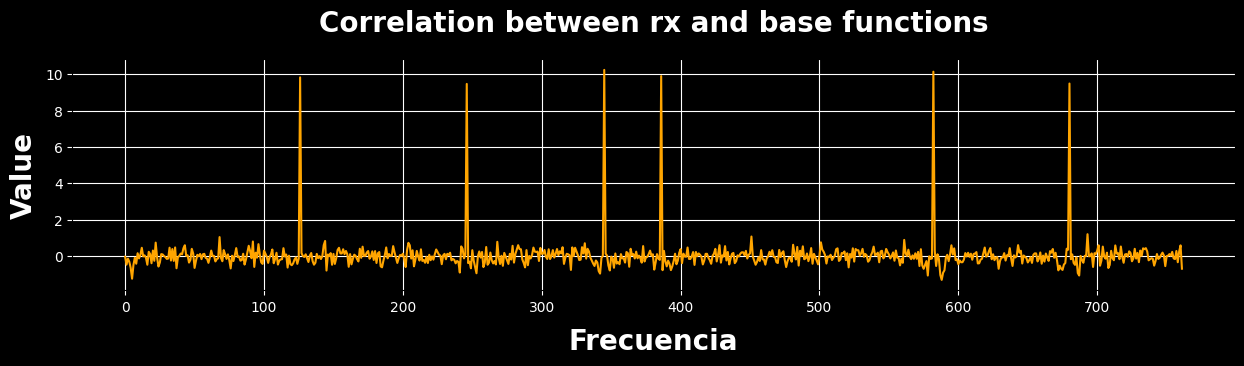

In [ ]:
#-----------------------------------------------------FUNCIONES------------------------------------------------------------------------
# Genera la waveform en tiempo de la funcion base para correlacionar con la rx_signal
def gen_waveform_dem(symb ,sf, Bw, delta, samples):

  Ts =2**sf
  T = 1/Bw
  wf = []

  fMax = (2**sf-1)*Bw/(2**sf)
  k = symb

  for n in range(samples):
    f = k*Bw/(2**sf)
    t = k*T
    if (f > fMax):
      k = k-Ts
      f = k*Bw/(2**sf)
    sample = (1/(np.sqrt(2**sf)))*np.exp(-1j*2*np.pi*f*t*1/2)
    wf.append(sample)

    k += delta
  return  wf

def correlate_base_function(rx_waveform_t, f_base):
  return np.dot(rx_waveform_t, f_base)

# Demodula la señal recibida (generada anteriormente)
def demodulate_waveform(rx_signal, sf, Bw, delta, samples, n_data, len_preamb_sync):
  rx_symbol = []
  corr = []
  max = 0

  for i in range(n_data):
    for f in range(2**sf-1):
      func_base = gen_waveform_dem(f, sf, Bw, delta, samples)
      corr_temp = correlate_base_function(rx_signal[(len_preamb_sync*samples) + i*samples: samples+i*samples + (len_preamb_sync*samples)], func_base)
      corr.append(corr_temp)

      if (corr_temp > max):
        max = corr_temp
        symbol = f

    max = 0
    rx_symbol.append(symbol)
  return rx_symbol, corr
# Calcula la cantidad de errores de simbolos
def decisor_rx_symbol(tx_signal, rx_estimado, n_data):

  error = 0
  for i in range(n_data):
    if (tx_signal[i] != rx_estimado[i]):
      error +=1
  return error/n_data



#----------------------------------------------------------MAIN--------------------------------------------------------------------------
# PARAMETROS A UTILIZAR
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
n_data = 6 # numero de datos a transmitir
len_preamb = 4 # Tamaño del preambulo
len_sync = 2 # Tamaño de down-chirp de sincronizacion
len_preamb_sync = len_preamb + len_sync
len_packet_tx = n_data+len_preamb_sync # Tamaño del paquete a transmitir
delta = 0.1
samples = int(2**sf*1/delta)
variance= 0.13

rx_symbol, corr = demodulate_waveform(rx_signal, sf, Bw, delta, samples, n_data, len_preamb_sync)
error = decisor_rx_symbol(symbs, rx_symbol, n_data)

print("Error de simbolos", error)

for i in range(n_data):
    print("Simbolo transmitido ", symbs[i])
    print("Simbolo estimado", rx_symbol[i])

fig3, ax5 = plt.subplots(1, figsize=(15, 3))
simple_plot(ax5,fig3,'Frecuencia','Value','Correlation between rx and base functions')
ax5.plot(np.real(corr), color = 'orange')
ax5.grid(color = 'white')
plt.show()

# Espectrograma

El espectrograma puede definirse como un gráfico de intensidad de la magnitud de la transformada de Fourier de tiempo corto (STFT). La STFT es simplemente una secuencia de FFTs de segmentos de datos divididos en ventanas, donde las ventanas suelen solaparse en el tiempo, normalmente en un 25-50%.

Un espectrograma muestra la intensidad de la señal utilizando colores: cuanto más brillante sea el color, mayor será la energía de la señal.

Generalizando y resumiendo lo que es un espectrograma, muestra como se distribuye la intensidad de la señal en cada frecuencia que se encuentra en la señal.

A continuacion se llama a la funcion que implementa el espectrograma, se utilizo la funcion provista por python llamada spectrogram.


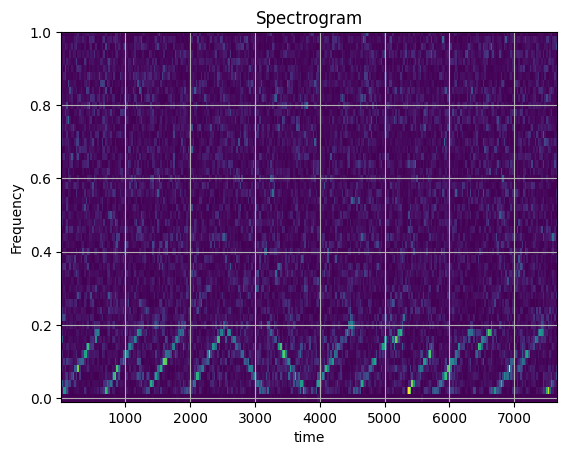

In [ ]:
def plot_spectrogram(title, rx_waveform_t, samples):
  ff, tt, Sxx = spectrogram(rx_waveform_t , fs =samples, nperseg=100, noverlap=50, mode='psd')
  plt.pcolormesh(tt, ff, Sxx)
  plt.title(title)
  plt.xlabel('time')
  plt.ylabel('Frequency')
  plt.axis(ymax = 1)
  plt.grid()

plot_spectrogram("Spectrogram", np.real(rx_signal), samples=2)
plt.show()

# Optimizacion de preambulo

### **System Model**

En LoRa cada trama se inicializa con un preambulo, en el cual, el chirrido base "$x$" de tamaño $M≜2^{SF}$ es repetido N veces.

Se llama $h$ al ruido del canal. El problema de la detección original planteado por el paper es una decisión binaria que sigue
$$\left\{\begin{matrix}H_{0}: y_{n} = w_{n}
\\
H_{1}: y_{n} = \sqrt{\rho}hx+ w_{n}
\end{matrix}\right.$$
donde $n= 0, 1, ..., N-1$.

Además $\rho$ es la potencia de transmisión, y $w_{n}$ representa los simbolos de la señal que forman el preambulo (en el envío).

### **Proposed scheme**
#### *A. Deteccion de preambulo basada en umbrales*

La idea basica de esta detección es detectar N secuencias conocidas consecutivamente, si ese simbolo es el del chirrido base $x$ detectado k veces, decimos que estamos en presencia de preambulo, sino la ausencia. Recordar que cada chirrido lo podemos demodular con el dechirping. Usando esto se presenta un algoritmo de detección del preambulo.

##### *Algortimo 1:*
Paso 1)
Realizar el "dechirping" de la señal recibida {$y_{n}$}, siguiendo la DFT:

$$Y_{n} = 1_{M}^{T}(x^{*}\odot y_{n}), n = 0, 1, ..., N-1$$

Esto es el mismo proceso que hemos realizado, pero en nuestra fuente se refiere exclusivamente al segmento de señal que representa el preambulo. Lo que rescatamos de esta definición, es que $Y_{n}$ es la combinaciones de simbolos que se repiten N veces. Es decir, si el preambulo está formado por el chirrido base con frecuencia inicial cero, repetido 4 veces, $Y_{n} = [0,0,0,0]$. N significa la cantidad de veces en el que esta trama es repetida, pero esto no coincide con la implemetntación que venimos implementando, sin embargo se explica más a detalle el uso de parámetros el informe en pdf que realizamos.

Paso 2)
Se declara la presencia del preambulo si:
$$\sum_{n=1}^{N}I(A_{n}(\gamma ))\geq k$$
donde I es un indicador de funcion, que es uno cuando el argumento es verdadero o cero en otro caso. También
$$A_{n}(\gamma )=Re\left \{ h^{*}Y_{n} \right \}\geq \gamma
$$ para una detección coherente.
De aquí se denota que $γ$ es el umbral de deteccion del chirrido base en cada periodo de simbolo, y k el umbral que denota el numero de veces que se detecta el chirrido base en N .

El paper de fuente se basa en estos dos umbrales para optimizar la deteccion.

#### *B. Optimizacion de umbrales*
##### *Proposicion I:*
Para el algoritmo uno la probabilidad de detectar correctamente el preambulo cuando este está prente es:
$$P_{D}(k,\gamma)=\sum_{i=k}^{N}\binom{N}{i}(p(\gamma) )^{i} (1-p(\gamma))^{N-i}$$
donde

$p(\gamma)= Q\left ( \sqrt{\frac{2}{|h|^{2}\rho \sigma^{2} }}\gamma \ -\ \sqrt{\frac{2|h|^{2}\rho }{\sigma^{2}}}  \right )$

También se define el rango de falsa alarma (la probabilidad de detectar incorrectamente el preambulo cuando está ausente):
$$P_{F}(k,\gamma)=\sum_{i=k}^{N}\binom{N}{i}(q(\gamma) )^{i} (1-q(\gamma))^{N-i}$$
donde

$q(\gamma)= Q\left ( \sqrt{\frac{2}{|h|^{2}\rho \sigma^{2}}\gamma } \right )$

Para ambos casos planteados por el paper (coherente/nocoherente), $A_{n}(\gamma)$ es una variable aleatoria con las probabilidades $p(\gamma)$ y $q(\gamma)$ correspondidas para las hipótesis $H_{0/1}$. De este modo, $\sum_{n=1}^{N}I(A_{n}(\gamma ))$ es una variable binomial variable tal que $Pr(A_{n}=i|H_{1}) = \binom{N}{i}(p(\gamma ))^{i}(1-p(\gamma ))^{N-i}$ y $Pr(A_{n}=i|H_{0}) = \binom{N}{i}(q(\gamma ))^{i}(1-q(\gamma ))^{N-i}$. De aquí las funciones de probabilidad $P_D$ y $P_F$ planetadas.

El objetivo del paper, es maximizar la probabilidad de detección del preambulo $P_D$ contrarestando el rango de falsa alarma $P_F$. Es decir la optimización de los umbrales $k$ y $\gamma$ siguiendo:

$$\underset{1\leq k\leq N,\gamma }{maximize} \ P_D(k,\gamma)\ sujeto\  a \ P_F(k,\gamma)\leq  \alpha$$

donde $α$ es la maxima tolerancia para la falsa alarma.

##### *Proposicion II:*

La optima solucion para lo planteado, viene dado por
$$k^{*} = \underset{1\leq k\leq N}{argmax}\ P_D(k,g(k,\alpha)),$$
$$\gamma^{*} = g(k^{*},\alpha)$$

De aqui, se define $g(k,α)$ es la inversa de la funcion $P_F(k,\gamma) = \alpha$ con respecto a $\gamma$ para un $k$ dado. Es decir, el valor de $\gamma$ para que $P_F = \alpha$.

Esto se prueba dado un $k$, $P_D$ y $P_F$ son decrecientes en $\gamma$. Entonces el valor de $\gamma$ maximiza $P_D$ sujeto a la condicion de $P_F \leq \alpha$ bajo la forma de $\gamma = g(k,\alpha)$.



# Ruido multiplicado

<ipython-input-7-53ff0fd5d32f>:156: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax1.stem(symbs[0:len_packet_tx], use_line_collection = True)


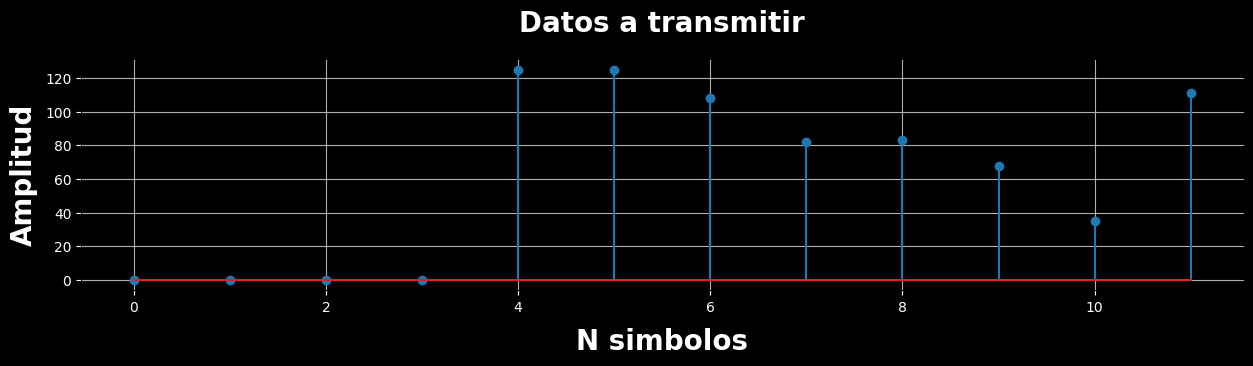

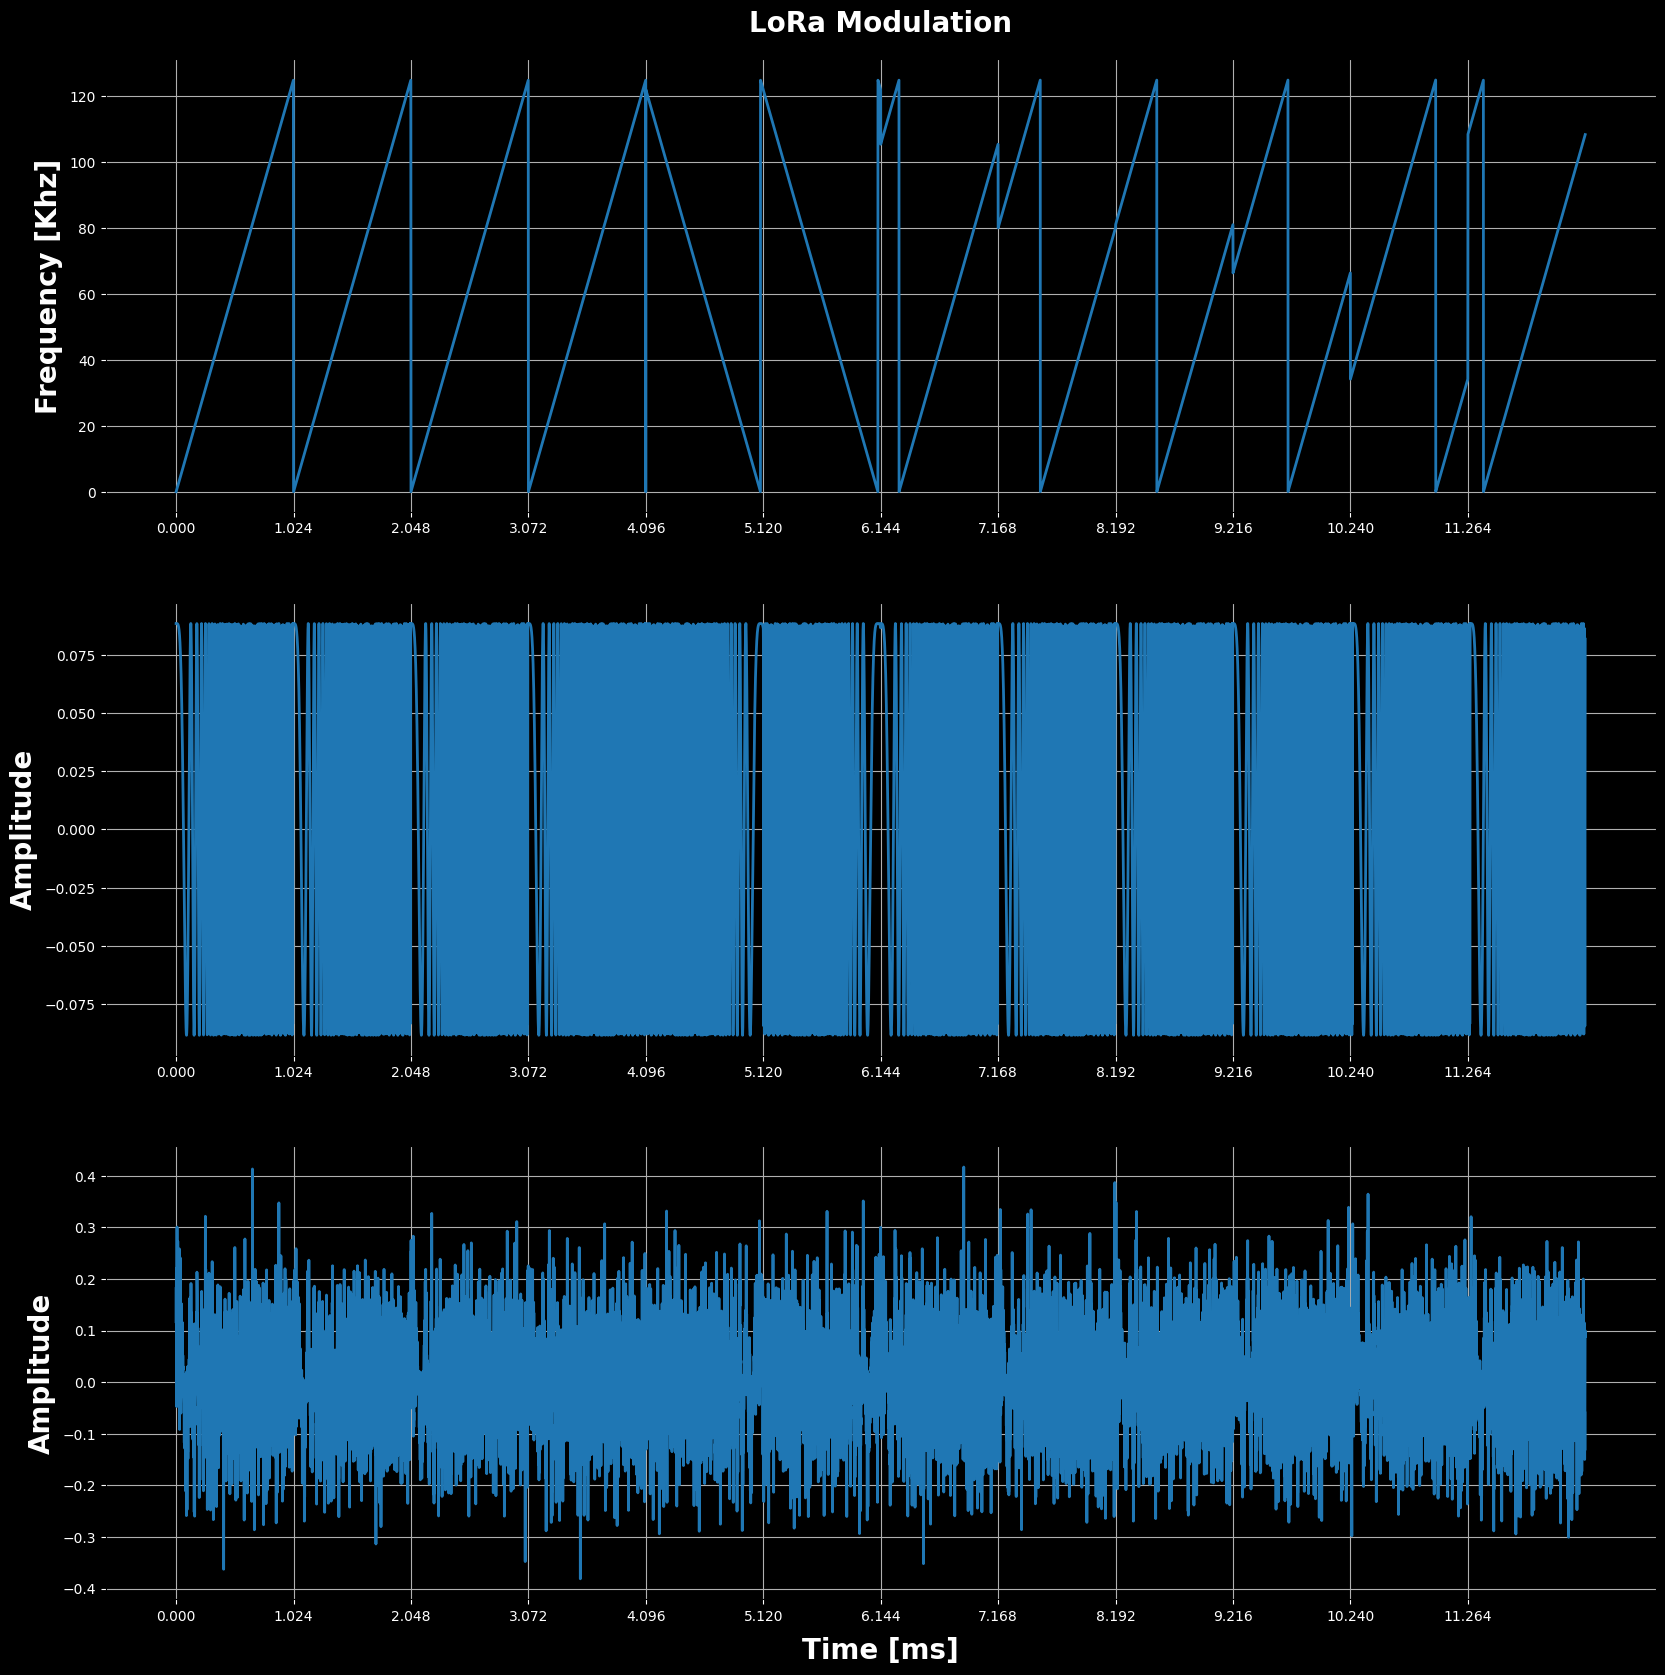

In [ ]:
#                                                         Con preambulo                                               #
# Genera el chirp de acuerdo al simbolo recibido: puede ser up-chirp, down-chirp
def generate_chirp(simbolo, sf, Bw, time_interval, samples):

  M = 2**sf
  Ts = M/np.abs(Bw)
  wf_f = []

  for i in range(samples):
    wf_f.append((simbolo*np.abs(Bw)/M + Bw/Ts*time_interval[i]) % np.abs(Bw))

  return wf_f
# Genera los simbolos aleatoriamente
def generate_symbols(sf, n_data, Bw, samples,symbs):

  data = []
  chirps = np.array([])
  t_c = np.linspace(0, Ts, samples)

  for i in range(n_data):
    data.append(np.random.randint(0, 2**sf))
    chirps = np.append(chirps, generate_chirp(data[i], sf, Bw, t_c, samples))

  return np.concatenate((symbs,data)), chirps

# Genera el simbolo de sincronizacion
def generate_sync(length_sync, Bw, sf, samples, symbs):

  f_0 = Bw
  M = 2**sf
  Ts = M/Bw
  data = []
  sync = np.array([])
  t_c = np.linspace(0, Ts, samples)

  for i in range(length_sync):
    data.append(f_0)
    sync = np.append(sync, generate_chirp(f_0, sf, -Bw,  t_c, samples))

  return np.concatenate((symbs,data)), sync


#       Genera el preambulo       #

def generate_preamble(length_preamb, Bw, Ts, samples):
  data = []
  f_0 = 0
  preamble = np.array([])
  t_c = np.linspace(0, Ts, samples)

  for i in range(length_preamb):
    data.append(f_0)
    preamble = np.append(preamble, generate_chirp(f_0, sf, Bw,  t_c, samples))

  return np.array(data), preamble


#   Concatena los chirps    #
def concatenate_chirps(preamble, sync, data_tx, Ts, samples, len_packet_tx):

  packet_tx = np.array([])
  packet_tx2 = np.array([])
  t = np.linspace(0, len_packet_tx*Ts, len_packet_tx*samples)

  tx_packet = np.append(preamble, sync)
  packet_tx2 = np.append(tx_packet, data_tx)

  return packet_tx2, t

#     Waveform en tiempo    #
def waveform_chirp_time(symb, sf, Bw, delta, samples):

  Ts =2**sf
  T = 1/Bw
  wf = np.array([])

  fMax = (2**sf-1)*Bw/(2**sf)
  k = symb

  for n in range(samples):
    f = k*Bw/(2**sf)
    t = k*T
    if (f > fMax):
      k = k-Ts
      f = k*Bw/(2**sf)

    sample = (1/(np.sqrt(2**sf)))*np.exp(1j*2*np.pi*f*t*1/2)
    wf = np.append(wf, sample)

    k += delta

  return  wf


#                       ruido gaussiano en el canal                   #
def add_noise_gaussiano(signal, variance):
    noise = generate_awgn(0, variance, len(signal))
    rx_signal_with_noise = signal * (1 + noise)
    return rx_signal_with_noise, 1+noise
    return signal, variance
def generate_awgn(mean, variance, samples):
    return np.random.normal(mean, variance, samples)  # Creando muestra de ruido


#                               plots                                   #
def plot_waveform(ax, t, wf, axis_x_label, axis_y_label, title, Ts, len_packet_tx):

  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
  ax.set_xticks(np.arange(0, len_packet_tx, Ts))
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
  ax.plot(t, wf, lw=2)
  ax.grid()
def simple_plot(ax, fig, axis_x_label, axis_y_label, title):
  fig.set_facecolor('black')
  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')

#---------------------------------MAIN---------------------------------------------------------------

# PARAMETROS A UTILIZAR
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
n_data = 6 # numero de datos a transmitir
len_preamb = 4 # Tamaño del preambulo
len_sync = 2 # Tamaño de down-chirp de sincronizacion
len_preamb_sync = len_preamb + len_sync
len_packet_tx = n_data+len_preamb_sync # Tamaño del paquete a transmitir
delta = 0.1
samples = int(2**sf*1/delta)
variance= 1

# Arreglos de los simbolos a transmitirse
packet_symbs_t = np.array([])
packet_preamb_t = np.array([])
packet_sync_t = np.array([])
packet_full_tx_t = np.array([])

# Se generan los distintos chirp
symbs, preamble        = generate_preamble(len_preamb, Bw, Ts, samples)
symbs, sync           = generate_sync(len_sync, Bw, sf, samples, symbs)
symbs, data_tx_f  = generate_symbols(sf, n_data, Bw, samples,symbs)
packet_tx_f, t  = concatenate_chirps(preamble, sync, data_tx_f, Ts, samples, len_packet_tx)

# Se muestran los datos a transmitir generados aleatoriamente
fig1, ax1 = plt.subplots(1, figsize=(15, 3))
xt = np.linspace(0, len_packet_tx, len_packet_tx)
simple_plot(ax1,fig1,'N simbolos','Amplitud','Datos a transmitir')
ax1.stem(symbs[0:len_packet_tx], use_line_collection = True)
ax1.grid()

# Se generan las waveform en tiempo
for i in range(n_data):
    packet_symbs_t = np.append(packet_symbs_t, waveform_chirp_time(symbs[i], sf, Bw, delta, samples))

for j in range(len_preamb):
    packet_preamb_t = np.append(packet_preamb_t, waveform_chirp_time(0, sf, Bw, delta, samples))

for k in range(len_sync):
    packet_sync_t = np.append(packet_sync_t, waveform_chirp_time(-Bw, sf, Bw, delta, samples))


# rand + rand *j
packet_full_tx_t = np.append(packet_full_tx_t, packet_preamb_t)
packet_full_tx_t = np.append(packet_full_tx_t, packet_sync_t)
packet_full_tx_t = np.append(packet_full_tx_t, packet_symbs_t)

# Se añade el ruido gaussiano
rx_signal,h = add_noise_gaussiano(packet_full_tx_t, variance)

# Se grafica las distintas waveform
fig3, [ax2, ax3, ax4] = plt.subplots(3, figsize=(20, 20))
fig3.patch.set_facecolor('black')

# Grafico Amplitud vs tiempo
t2 = np.linspace(0, Ts*len_packet_tx, len_packet_tx*samples)

# Grafico sin ruido gaussiano
plot_waveform(ax3, t2, np.real(packet_full_tx_t), "", "Amplitude", "", Ts, len_packet_tx)

# Grafico con ruido gaussiano
plot_waveform(ax4, t2, np.real(rx_signal), "Time [ms]", "Amplitude", "", Ts, len_packet_tx)

# Grafico frecuencia vs tiempo
plot_waveform(ax2, t, packet_tx_f, "", "Frequency [Khz]", "LoRa Modulation", Ts, len_packet_tx)

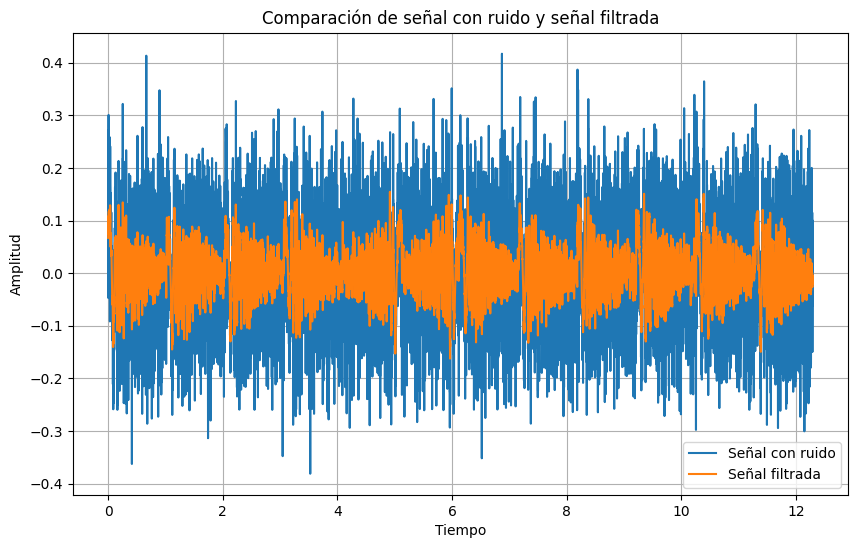

Potencia de la señal  -23.513616784159765
Error de simbolos 0.0
Simbolo transmitido  0
Simbolo estimado 0
Simbolo transmitido  0
Simbolo estimado 0
Simbolo transmitido  0
Simbolo estimado 0
Simbolo transmitido  0
Simbolo estimado 0


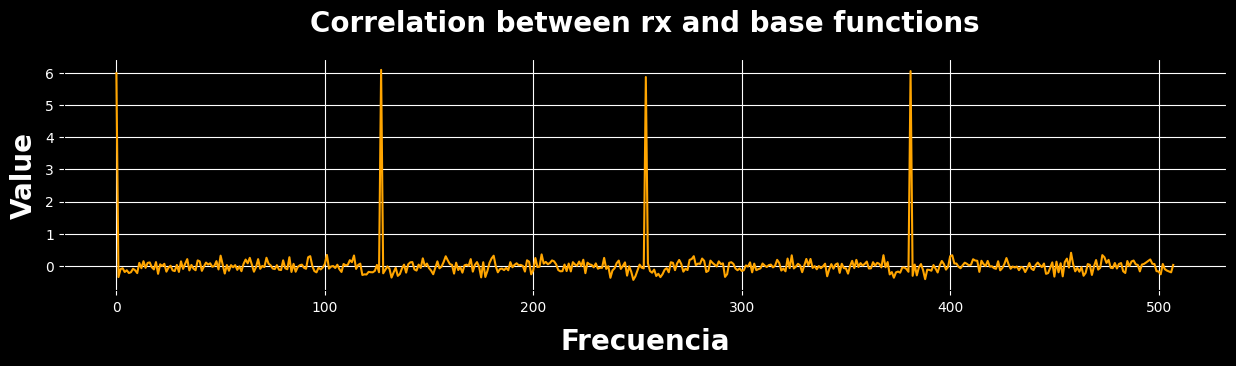

K optimized 1
Gamma optimized 0.10000029504299164
Probabilidd de deteccion de preambulo correcto 0.0002121171587689136  PF  0.42576567160678896
+---------+--------+------------+-------------+-------------+
|   alpha |   kast |   gammaast |          PD |          PF |
+=========+========+============+=============+=============+
|  1e-07  |      6 |   0.117174 | 5.25714e-07 | 9.99956e-08 |
+---------+--------+------------+-------------+-------------+
|  1e-06  |      6 |   0.104669 | 4.5831e-06  | 1.00002e-06 |
+---------+--------+------------+-------------+-------------+
|  1e-05  |      5 |   0.112602 | 3.76306e-05 | 1.00001e-05 |
+---------+--------+------------+-------------+-------------+
|  0.0001 |      4 |   0.120408 | 0.000302004 | 0.000100003 |
+---------+--------+------------+-------------+-------------+
|  0.001  |      4 |   0.101126 | 0.00258259  | 0.000999976 |
+---------+--------+------------+-------------+-------------+
|  0.01   |      3 |   0.103282 | 0.020147    | 0.

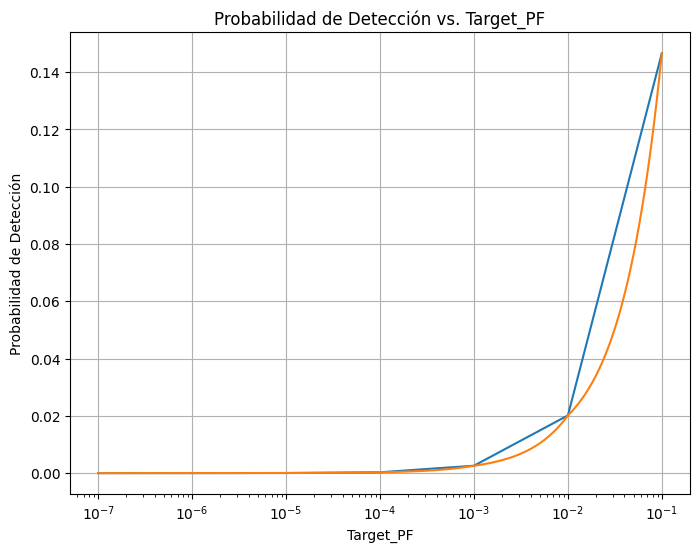

Resultados de Pd para diferentes valores de target_pf: [5.25714434e-07 4.58309991e-06 3.76305843e-05 3.02004371e-04
 2.58259274e-03 2.01470336e-02 1.46636926e-01]


In [ ]:
#-----------------------------------------------------FUNCIONES------------------------------------------------------------------------
# Genera la waveform en tiempo de la funcion base para correlacionar con la rx_signal
def gen_waveform_dem(symb ,sf, Bw, delta, samples):

  Ts =2**sf
  T = 1/Bw
  wf = []

  fMax = (2**sf-1)*Bw/(2**sf)
  k = symb

  for n in range(samples):
    f = k*Bw/(2**sf)
    t = k*T
    if (f > fMax):
      k = k-Ts
      f = k*Bw/(2**sf)
    sample = (1/(np.sqrt(2**sf)))*np.exp(-1j*2*np.pi*f*t*1/2)
    wf.append(sample)

    k += delta
  return  wf

#           correlacion   #
def correlate_base_function(rx_waveform_t, f_base):
  return np.dot(rx_waveform_t, f_base)

# Demodula la señal recibida (generada anteriormente)
def demodulate_waveform(filtered_signal, sf, Bw, delta, samples, n_data, len_preamb_sync):
  rx_symbol = []
  corr = []
  max = 0

  for i in range(n_data):
    for f in range(2**sf-1):
      func_base = gen_waveform_dem(f, sf, Bw, delta, samples)
      corr_temp = correlate_base_function(filtered_signal[(len_preamb_sync*samples) + i*samples: samples+i*samples + (len_preamb_sync*samples)], func_base)
      corr.append(corr_temp)

      if (corr_temp > max):
        max = corr_temp
        symbol = f

    max = 0
    rx_symbol.append(symbol)
  return rx_symbol, corr
# Calcula la cantidad de errores de simbolos
def decisor_rx_symbol(tx_signal, rx_estimado, n_data):

  error = 0
  for i in range(n_data):
    if (tx_signal[i] != rx_estimado[i]):
      error +=1
  return error/n_data

#              pasa la potencia con control           #
def potenciaDB(signal):
    signal_w = np.abs(np.array(signal))**2
    signal_avg = np.mean(signal_w)

    if signal_avg <= 0:  # Verificar si la potencia es no negativa
        return float('-inf')  # Devolver infinito negativo en caso de potencia cero o negativa
    else:
        return 10 * np.log10(signal_avg)  # Calcular potencia en dB

#----------------------------------------------------------MAIN--------------------------------------------------------------------------
# PARAMETROS A UTILIZAR
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
n_data = 4 # numero de datos a transmitir
len_preamb = 4 # Tamaño del preambulo
len_sync = 2 # Tamaño de down-chirp de sincronizacion
len_preamb_sync = len_preamb + len_sync
len_packet_tx = n_data+len_preamb_sync # Tamaño del paquete a transmitir
delta = 0.1
samples = int(2**sf*1/delta)
variance= 1



#                                 Funcion de filtro                   #
def apply_moving_average_filter(signal, window_size):
    filtered_signal = np.convolve(signal, np.ones(window_size)/window_size, mode='same')
    return filtered_signal


# Aplicar el filtro de media móvil
filtered_signal = apply_moving_average_filter(rx_signal, window_size=10)

# Comparar señal original con ruido y señal filtrada
plt.figure(figsize=(10, 6))
plt.plot(t2, rx_signal, label='Señal con ruido')
plt.plot(t2, filtered_signal, label='Señal filtrada')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Comparación de señal con ruido y señal filtrada')
plt.legend()
plt.grid(True)
plt.show()


rx_symbol, corr = demodulate_waveform(filtered_signal, sf, Bw, delta, samples, n_data, len_preamb_sync)
error = decisor_rx_symbol(symbs, rx_symbol, n_data)

print("Potencia de la señal ", potenciaDB(filtered_signal))
rx_symbol, corr = demodulate_waveform(filtered_signal, sf, Bw, delta, samples, n_data, len_preamb_sync)
error = decisor_rx_symbol(symbs, rx_symbol, n_data)

print("Error de simbolos", error)


for i in range(n_data):
    print("Simbolo transmitido ", symbs[i])
    print("Simbolo estimado", rx_symbol[i])

fig3, ax5 = plt.subplots(1, figsize=(15, 3))
simple_plot(ax5,fig3,'Frecuencia','Value','Correlation between rx and base functions')
ax5.plot(np.real(corr), color = 'orange')
ax5.grid(color = 'white')
plt.show()


#               unused  #

def rho_from_snr(snr_dB):
    snr = 10**(snr_dB / 10.0)
    rho = snr / (snr + 1)
    return rho


#                   PD                              #
def PD(k, N, snr_dB, variance,gamma,h):
    #rho = snr_dB
    #rho = rho_from_snr(snr_dB)
    rho_dB = snr_dB
    rho = 10**(rho_dB / 10.0)  # Convertir de dB a escala lineal
    result = 0
    #result = 0

    for i in range(k, N+1):

        pd_term = binom(N, i) * (norm.sf(np.sqrt(2/((abs(h)**2)*rho*sigma**2))*gamma - np.sqrt(2*(abs(h)**2)*rho/sigma**2)))**i * (1 - norm.sf(np.sqrt(2/((abs(h)**2)*rho*sigma**2))*gamma - np.sqrt(2*rho*(abs(h)**2)/sigma**2)))**(N-i)
        #print(pd_term)
        result += pd_term
        #print(f"PD acumulada en iteración {i}: {result}")

    return result

#                               PF              #
def PF(k, N, snr_dB, variance, gamma,h):
    #rho = snr_dB
    #rho = rho_from_snr(snr_dB)
    #result = 0
    rho_dB = snr_dB
    rho = 10**(rho_dB / 10.0)  # Convertir de dB a escala lineal
    result = 0

    for i in range(k, N+1):
        #h_real = np.random.normal(0, 1, 1)  # Parte real de h
       # h_imag = np.random.normal(0, 1, 1)  # Parte imaginaria de h
       # h = h_real + 1j * h_imag  # Combinar parte real e imaginaria para formar h
        pf_term = binom(N, i) * (norm.sf(np.sqrt(2/((abs(h)**2)*rho*sigma**2))*gamma ))**i * (1 - norm.sf(np.sqrt(2/((abs(h)**2)*rho*sigma**2))*gamma))**(N-i)
        #pf_term = binom(N, i) * (norm.sf(np.sqrt(2/(rho*sigma**2))*gamma ))**i * (1 - norm.sf(np.sqrt(2/(rho*sigma**2))*gamma))**(N-i)
        #print("eee", pf_term)
        result += pf_term
        #print(f"PF acumulada en iteración {i}: {result}")

    return result
#                         Aproximación de gamma por método numérico   #
def find_gamma_for_pf_target(k, N, snr_dB, sigma, target_pf,h):
    def objective_function(gamma):
        return PF(k, N, snr_dB, sigma, gamma,h) - target_pf

    gamma_lower_bound = 0.1
    gamma_upper_bound = 10.0

    while gamma_upper_bound - gamma_lower_bound > 1e-6:
        gamma_mid = (gamma_lower_bound + gamma_upper_bound) / 2
        if objective_function(gamma_mid) < 0:
            gamma_upper_bound = gamma_mid
        else:
            gamma_lower_bound = gamma_mid

    return (gamma_lower_bound + gamma_upper_bound) / 2

#                       K optimizado      #
def calcular_k_optimizado(N, snr_dB, sigma, alfa,h):
  kmax = 0
  pdmax = 0
  for k in range(1,N):
    pdtemp = PD(k, N, snr_dB, sigma,find_gamma_for_pf_target(k, N, snr_dB, sigma, alfa,h),h)
    #print(pdtemp)
    if pdtemp> pdmax:
      pdmax = pdtemp
      kmax = k

  #print(kmax)
  return kmax

# Ejemplo de uso
k = 3
N = 8
#snr_dB = 20  # Puedes ajustar este valor según la aplicación
sigma = 1
target_pf = 0.5#1e-1 #org -3
pds = np.array([])
#gamma_solution = find_gamma_for_pf_target(k, N, snr_dB, sigma, target_pf)

#argumento_pd = PD(7,N,snr_dB,sigma,gamma_solution)
#h_real = np.random.normal(0, 1, 1)  # Parte real de h
#h_imag = np.random.normal(0, 1, 1)  # Parte imaginaria de h
h = 1 + 1j   # Combinar parte real e imaginaria para formar h

kast = calcular_k_optimizado(N,potenciaDB(filtered_signal), variance, target_pf,h)
gammaast = find_gamma_for_pf_target(kast, N,potenciaDB(filtered_signal), variance, target_pf,h)
#print("Valor de gamma aproximado:", gamma_solution)
#print("PF correspondiente al valor de gamma encontrado:", PF(k, N,snr_dB, sigma, gamma_solution))
#print("Un argumento de pd: ", argumento_pd)
print("K optimized",kast)
print("Gamma optimized", gammaast)
pdi=PD(5, N, potenciaDB(filtered_signal), variance,gammaast,h)
print("Probabilidd de deteccion de preambulo correcto",pdi, " PF ",PF(kast, N, potenciaDB(filtered_signal), variance,gammaast,h) )
#pds = np.append(pds,pdi)
target_pfs = np.logspace(-7, -1, num=7)
results = []
for target_pf in target_pfs:
    #kast = calcular_k_optimizado(N, potenciaDB(filtered_signal), variance, target_pf,h)
    #gammaast = find_gamma_for_pf_target(kast, N, potenciaDB(filtered_signal), variance, target_pf,h)
    #pdi = PD(kast, N, potenciaDB(filtered_signal), variance, gammaast,h)
    #pds= np.append(pds, pdi)
    kast = calcular_k_optimizado(N, potenciaDB(filtered_signal), variance, target_pf, h)
    gammaast = find_gamma_for_pf_target(kast, N, potenciaDB(filtered_signal), variance, target_pf, h)
    pdi = PD(kast, N, potenciaDB(filtered_signal), variance, gammaast, h)
    pfi = PF(kast, N, potenciaDB(filtered_signal), variance, gammaast, h)
    results.append([target_pf, kast, gammaast, pdi, pfi])
    pds = np.append(pds,pdi)


headers = ["alpha", "kast", "gammaast", "PD", "PF"]
print(tabulate(results, headers=headers, tablefmt="grid"))
# Graficar los valores de pdi vs. target_pf con interpolación
plt.figure(figsize=(8, 6))
plt.semilogx(target_pfs, pds, marker='', linestyle='-')
target_pfs_interp = np.logspace(-7, -1, num=1000)  # Más puntos para interpolación
pds_smooth = np.interp(target_pfs_interp, target_pfs, pds)
plt.semilogx(target_pfs_interp, pds_smooth, marker='', linestyle='-')
plt.title('Probabilidad de Detección vs. Target_PF')
plt.xlabel('Target_PF')
plt.ylabel('Probabilidad de Detección')
plt.grid(True)
plt.show()

print("Resultados de Pd para diferentes valores de target_pf:", pds)

# Ruido aditivo

<ipython-input-87-342ce5d9c253>:27: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax1.stem(symbs[0:len_packet_tx], use_line_collection = True)


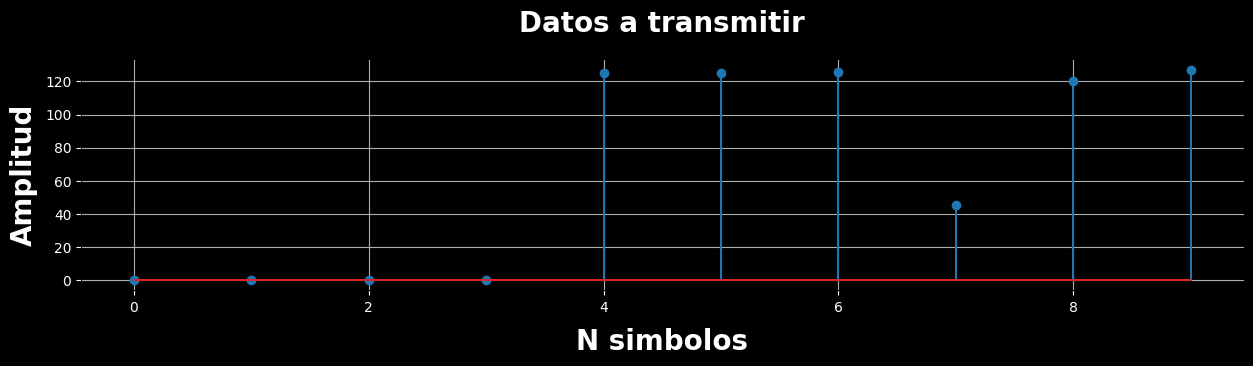

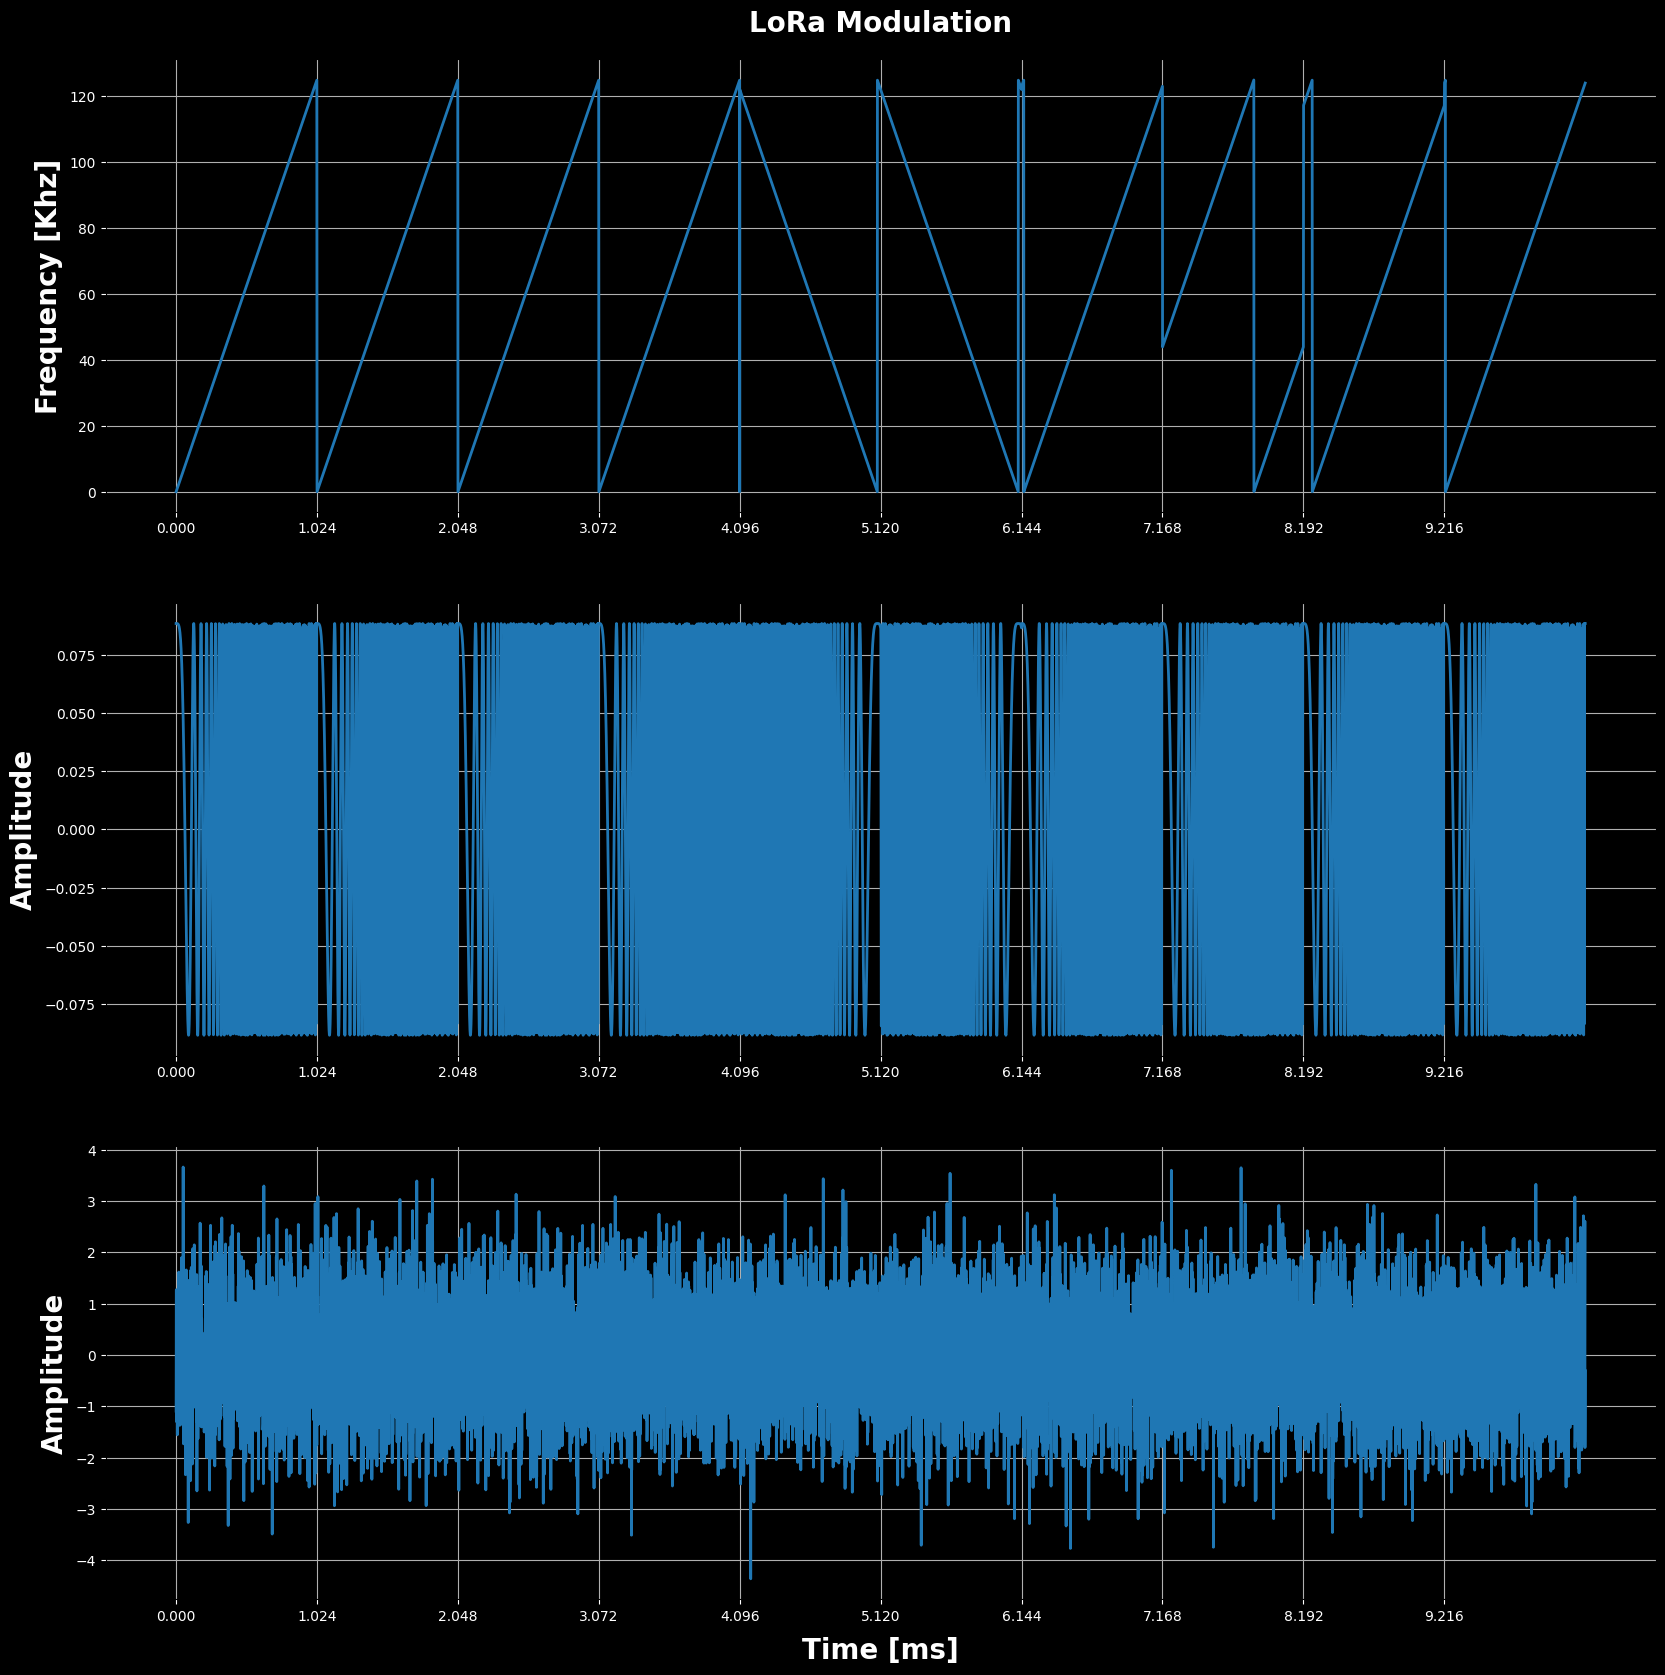

In [ ]:
def add_noise_gaussiano_aditivo(tx_signal, mean, variance):
  wn = generate_awgn(mean, variance, len(tx_signal))
  rx_signal = (tx_signal + wn)

  return rx_signal

def generate_awgn(mean, variance, samples):
  return np.random.normal(mean, variance, samples) #creando muestra de ruido


# Arreglos de los simbolos a transmitirse
packet_symbs_t = np.array([])
packet_preamb_t = np.array([])
packet_sync_t = np.array([])
packet_full_tx_t = np.array([])

# Se generan los distintos chirp
symbs, preamble        = generate_preamble(len_preamb, Bw, Ts, samples)
symbs, sync           = generate_sync(len_sync, Bw, sf, samples, symbs)
symbs, data_tx_f  = generate_symbols(sf, n_data, Bw, samples,symbs)
packet_tx_f, t  = concatenate_chirps(preamble, sync, data_tx_f, Ts, samples, len_packet_tx)

# Se muestran los datos a transmitir generados aleatoriamente
fig1, ax1 = plt.subplots(1, figsize=(15, 3))
xt = np.linspace(0, len_packet_tx, len_packet_tx)
simple_plot(ax1,fig1,'N simbolos','Amplitud','Datos a transmitir')
ax1.stem(symbs[0:len_packet_tx], use_line_collection = True)
ax1.grid()

# Se generan las waveform en tiempo
for i in range(n_data):
    packet_symbs_t = np.append(packet_symbs_t, waveform_chirp_time(symbs[i], sf, Bw, delta, samples))

for j in range(len_preamb):
    packet_preamb_t = np.append(packet_preamb_t, waveform_chirp_time(0, sf, Bw, delta, samples))

for k in range(len_sync):
    packet_sync_t = np.append(packet_sync_t, waveform_chirp_time(-Bw, sf, Bw, delta, samples))


packet_full_tx_t = np.append(packet_full_tx_t, packet_preamb_t)
packet_full_tx_t = np.append(packet_full_tx_t, packet_sync_t)
packet_full_tx_t = np.append(packet_full_tx_t, packet_symbs_t)

# Se añade el ruido gaussiano
rx_signal = add_noise_gaussiano_aditivo(packet_full_tx_t, 0, variance)

# Se grafica las distintas waveform
fig3, [ax2, ax3, ax4] = plt.subplots(3, figsize=(20, 20))
fig3.patch.set_facecolor('black')

# Grafico Amplitud vs tiempo
t2 = np.linspace(0, Ts*len_packet_tx, len_packet_tx*samples)

# Grafico sin ruido gaussiano
plot_waveform(ax3, t2, np.real(packet_full_tx_t), "", "Amplitude", "", Ts, len_packet_tx)

# Grafico con ruido gaussiano
plot_waveform(ax4, t2, np.real(rx_signal), "Time [ms]", "Amplitude", "", Ts, len_packet_tx)

# Grafico frecuencia vs tiempo
plot_waveform(ax2, t, packet_tx_f, "", "Frequency [Khz]", "LoRa Modulation", Ts, len_packet_tx)

Potencia de la señal  0.006076370499675078
Error de simbolos 0.0
Simbolo transmitido  0
Simbolo estimado 0
Simbolo transmitido  0
Simbolo estimado 0
Simbolo transmitido  0
Simbolo estimado 0
Simbolo transmitido  0
Simbolo estimado 0


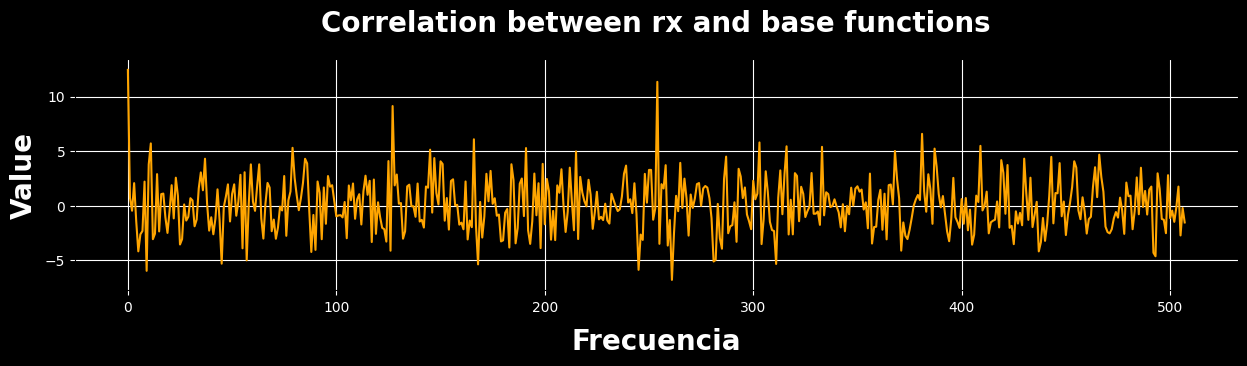

K optimized 4
Gamma optimized 0.7078856319189071
Probabilidd de deteccion de preambulo correcto 0.9996108926755384  pf  0.1000000802847988
+---------+--------+------------+----------+-------------+
|   alpha |   kast |   gammaast |       PD |          PF |
+=========+========+============+==========+=============+
|  1e-07  |      6 |   1.75718  | 0.309044 | 9.99998e-08 |
+---------+--------+------------+----------+-------------+
|  1e-06  |      6 |   1.56965  | 0.470115 | 9.99999e-07 |
+---------+--------+------------+----------+-------------+
|  1e-05  |      6 |   1.3641   | 0.649304 | 1e-05       |
+---------+--------+------------+----------+-------------+
|  0.0001 |      5 |   1.45058  | 0.822731 | 0.0001      |
+---------+--------+------------+----------+-------------+
|  0.001  |      5 |   1.17796  | 0.939116 | 0.001       |
+---------+--------+------------+----------+-------------+
|  0.01   |      5 |   0.848654 | 0.988948 | 0.00999999  |
+---------+--------+------------+--

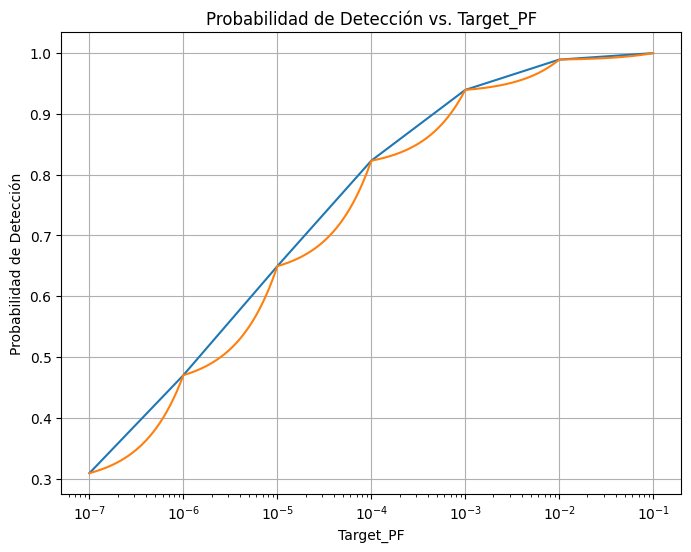

In [ ]:
print("Potencia de la señal ", potenciaDB(rx_signal))
rx_symbol, corr = demodulate_waveform(rx_signal, sf, Bw, delta, samples, n_data, len_preamb_sync)
error = decisor_rx_symbol(symbs, rx_symbol, n_data)

print("Error de simbolos", error)


for i in range(n_data):
    print("Simbolo transmitido ", symbs[i])
    print("Simbolo estimado", rx_symbol[i])

fig3, ax5 = plt.subplots(1, figsize=(15, 3))
simple_plot(ax5,fig3,'Frecuencia','Value','Correlation between rx and base functions')
ax5.plot(np.real(corr), color = 'orange')
ax5.grid(color = 'white')
plt.show()



def rho_from_snr(snr_dB):
    snr = 10**(snr_dB / 10.0)
    rho = snr / (snr + 1)
    return rho


def PD(k, N, snr_dB, variance,gamma):
    h = 1 + 1j
    #rho = rho_from_snr(snr_dB)
    rho_dB = snr_dB
    rho = 10**(rho_dB / 10.0)  # Convertir de dB a escala lineal
    result = 0

    for i in range(k, N+1):

        pd_term = binom(N, i) * (norm.sf(np.sqrt(2/((abs(h)**2)*rho*sigma**2))*gamma - np.sqrt(2*(abs(h)**2)*rho/sigma**2)))**i * (1 - norm.sf(np.sqrt(2/((abs(h)**2)*rho*sigma**2))*gamma - np.sqrt(2*rho*(abs(h)**2)/sigma**2)))**(N-i)
        #print(pd_term)
        result += pd_term
        #print(f"PD acumulada en iteración {i}: {result}")

    return result

def PF(k, N, snr_dB, variance, gamma):
    h = 1 + 1j
    #rho = rho_from_snr(snr_dB)
    rho_dB = snr_dB
    rho = 10**(rho_dB / 10.0)  # Convertir de dB a escala lineal
    result = 0

    for i in range(k, N+1):
        #h_real = np.random.normal(0, 1, 1)  # Parte real de h
       # h_imag = np.random.normal(0, 1, 1)  # Parte imaginaria de h
       # h = h_real + 1j * h_imag  # Combinar parte real e imaginaria para formar h
        pf_term = binom(N, i) * (norm.sf(np.sqrt(2/((abs(h)**2)*rho*sigma**2))*gamma ))**i * (1 - norm.sf(np.sqrt(2/((abs(h)**2)*rho*sigma**2))*gamma))**(N-i)
        #pf_term = binom(N, i) * (norm.sf(np.sqrt(2/(rho*sigma**2))*gamma ))**i * (1 - norm.sf(np.sqrt(2/(rho*sigma**2))*gamma))**(N-i)
        #print("eee", pf_term)
        result += pf_term
        #print(f"PF acumulada en iteración {i}: {result}")

    return result

def find_gamma_for_pf_target(k, N, snr_dB, sigma, target_pf):
    def objective_function(gamma):
        return PF(k, N, snr_dB, sigma, gamma) - target_pf

    gamma_lower_bound = 0.1
    gamma_upper_bound = 10.0

    while gamma_upper_bound - gamma_lower_bound > 1e-6:
        gamma_mid = (gamma_lower_bound + gamma_upper_bound) / 2
        if objective_function(gamma_mid) < 0:
            gamma_upper_bound = gamma_mid
        else:
            gamma_lower_bound = gamma_mid

    return (gamma_lower_bound + gamma_upper_bound) / 2


def calcular_k_optimizado(N, snr_dB, sigma, alfa):
  kmax = 0
  pdmax = 0
  for k in range(1,N):
    pdtemp = PD(k, N, snr_dB, sigma,find_gamma_for_pf_target(k, N, snr_dB, sigma, alfa))
    #print(pdtemp)
    if pdtemp> pdmax:
      pdmax = pdtemp
      kmax = k

 # print(kmax)
  return kmax

# Ejemplo de uso
k = 3
N = 8
snr_dB = 20  # Puedes ajustar este valor según la aplicación
sigma = 1
target_pf = 1e-1 #org -3
pds = np.array([])
#gamma_solution = find_gamma_for_pf_target(k, N, snr_dB, sigma, target_pf)

#argumento_pd = PD(7,N,snr_dB,sigma,gamma_solution)

kast = calcular_k_optimizado(N,potenciaDB(rx_signal), variance, target_pf)
gammaast = find_gamma_for_pf_target(kast, N,potenciaDB(rx_signal), variance, target_pf)
#print("Valor de gamma aproximado:", gamma_solution)
#print("PF correspondiente al valor de gamma encontrado:", PF(k, N,snr_dB, sigma, gamma_solution))
#print("Un argumento de pd: ", argumento_pd)
print("K optimized",kast)
print("Gamma optimized", gammaast)
pdi=PD(kast, N, potenciaDB(rx_signal), variance,gammaast)
print("Probabilidd de deteccion de preambulo correcto",pdi, " pf ",PF(kast, N, potenciaDB(rx_signal), variance,gammaast) )
#pds = np.append(pds,pdi)
target_pfs = np.logspace(-7, -1, num=7)
results = []

# Iterar sobre los diferentes valores de target_pf
for target_pf in target_pfs:
    kast = calcular_k_optimizado(N, potenciaDB(rx_signal), variance, target_pf)
    gammaast = find_gamma_for_pf_target(kast, N, potenciaDB(rx_signal), variance, target_pf)
    pdi = PD(kast, N, potenciaDB(rx_signal), variance, gammaast)
    pfi = PF(kast, N, potenciaDB(rx_signal), variance, gammaast)
    results.append([target_pf, kast, gammaast, pdi, pfi])
    pds = np.append(pds,pdi)

# Imprimir la tabla utilizando tabulate
headers = ["alpha", "kast", "gammaast", "PD", "PF"]
print(tabulate(results, headers=headers, tablefmt="grid"))

# Graficar los valores de pdi vs. target_pf con interpolación
plt.figure(figsize=(8, 6))
plt.semilogx(target_pfs, pds, marker='', linestyle='-')
target_pfs_interp = np.logspace(-7, -1, num=1000)  # Más puntos para interpolación
pds_smooth = np.interp(target_pfs_interp, target_pfs, pds)
plt.semilogx(target_pfs_interp, pds_smooth, marker='', linestyle='-')
plt.title('Probabilidad de Detección vs. Target_PF')
plt.xlabel('Target_PF')
plt.ylabel('Probabilidad de Detección')
plt.grid(True)
plt.show()

#print("Resultados de Pd para diferentes valores de target_pf:", pds)